In [1]:
import os
import math
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
x = [1,2,3,4,5]
y = ['a','b','c','d','e']
seed = 19
x = shuffle(x, random_state=seed)
y = shuffle(y, random_state=seed)
print(x)
print(y)

[2, 5, 4, 1, 3]
['b', 'e', 'd', 'a', 'c']


In [3]:
import numpy as np
root_path = os.getcwd()


class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, X : np.array, Y : np.array, batch_size : int = 8,input_size : tuple =(224, 224),
                 shuffle : bool =True):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
    
    
    def __len__(self):
        return int(len(self.X)/ self.batch_size)

    def __img_preprocess(self,image_path):
        img = cv2.imread(image_path)
        if img is None : 
            return None
            
        image = cv2.resize(img, self.input_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image/255
        
    
    def __get_data(self,x_batches, y_batches):
         # Generates data containing batch_size samples
        X_batchs = []
        Y_batches = []
        for x,y in zip(x_batches,y_batches):
            preprocessed_img =  self.__img_preprocess(x) 
            if preprocessed_img is None:
                continue
            X_batchs.append(preprocessed_img)
            Y_batches.append(y)
            

        X_batchs = np.array(X_batchs)
        Y_batches = np.array(Y_batches)
        
        return X_batchs,Y_batches
    



    def __getitem__(self, idx):
        #print()
        #print('getitem', idx)
        seed = np.random.randint(1,100)
        self.X = shuffle(self.X, random_state=seed)
        self.Y = shuffle(self.Y, random_state=seed)
  

        batch_x = self.X[idx * self.batch_size: (idx+1)* self.batch_size]
        batch_y = self.Y[idx * self.batch_size : (idx+1) * self.batch_size]
        
        cur_X,cur_Y = self.__get_data(batch_x,batch_y)
        return cur_X,cur_Y
        




    def on_epoch_end(self):
        print('on_epoch_end')
        #import sys
        #sys.exit()
        seed = np.random.randint(1,100)
        self.X = shuffle(self.X, random_state=seed)
        self.Y = shuffle(self.Y, random_state=seed)


In [4]:
result_list = np.array([0 for _ in range(4)])
print(result_list)

test_x = ["a","b","c"]
print(test_x.index("a"))

[0 0 0 0]
0


In [5]:
def OneHotEncoder(input_list :list):
    unique_class = set(input_list)
    unique_class = list(unique_class)
    result_list = []
    for temp in input_list:
        # create 0 array
        onehot_arr = np.array([0 for _ in range(len(unique_class))])
        onehot_arr[unique_class.index(temp)] = 1
        result_list.append(onehot_arr)
    return result_list,unique_class

In [6]:
# for mac delete .DS_Store
# find . -name '.DS_Store' -type f -delete


In [7]:

def load_dataset(dataset_path : str):
    x_test, y_test = [],[]
    encoding_label = []
    for cur_class in  os.listdir(dataset_path):

        temp_path = dataset_path+"/"+cur_class
        for file_name in os.listdir(temp_path):
            img_path = temp_path+"/"+file_name
            x_test.append(img_path)
            y_test.append(cur_class)

    y_test,encoding_label = OneHotEncoder(y_test)

    print("Encoded label : ",encoding_label)
    y_test = np.array(y_test)
    x_test = np.array(x_test)


    return x_test, y_test





input_size = (224,224)
input_shape = (224,224,3)
output_shape = 3
batch_size = 16


# load test path 
test_path = os.getcwd()+"/skin_cancer/test/"
x_test,y_test = load_dataset(test_path)


#load train path
train_path = os.getcwd()+"/skin_cancer/train/"
x_train,y_train = load_dataset(train_path)








Encoded label :  ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions']
Encoded label :  ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions']


In [8]:
test_gen = CustomDataGen(X=x_test,Y=y_test,batch_size=batch_size,input_size=input_size,shuffle=True)
train_gen = CustomDataGen(X=x_train,Y=y_train,batch_size=batch_size,input_size=input_size,shuffle=True)

Max index : 20
x :  (16, 224, 224, 3)
y :  (16, 3)


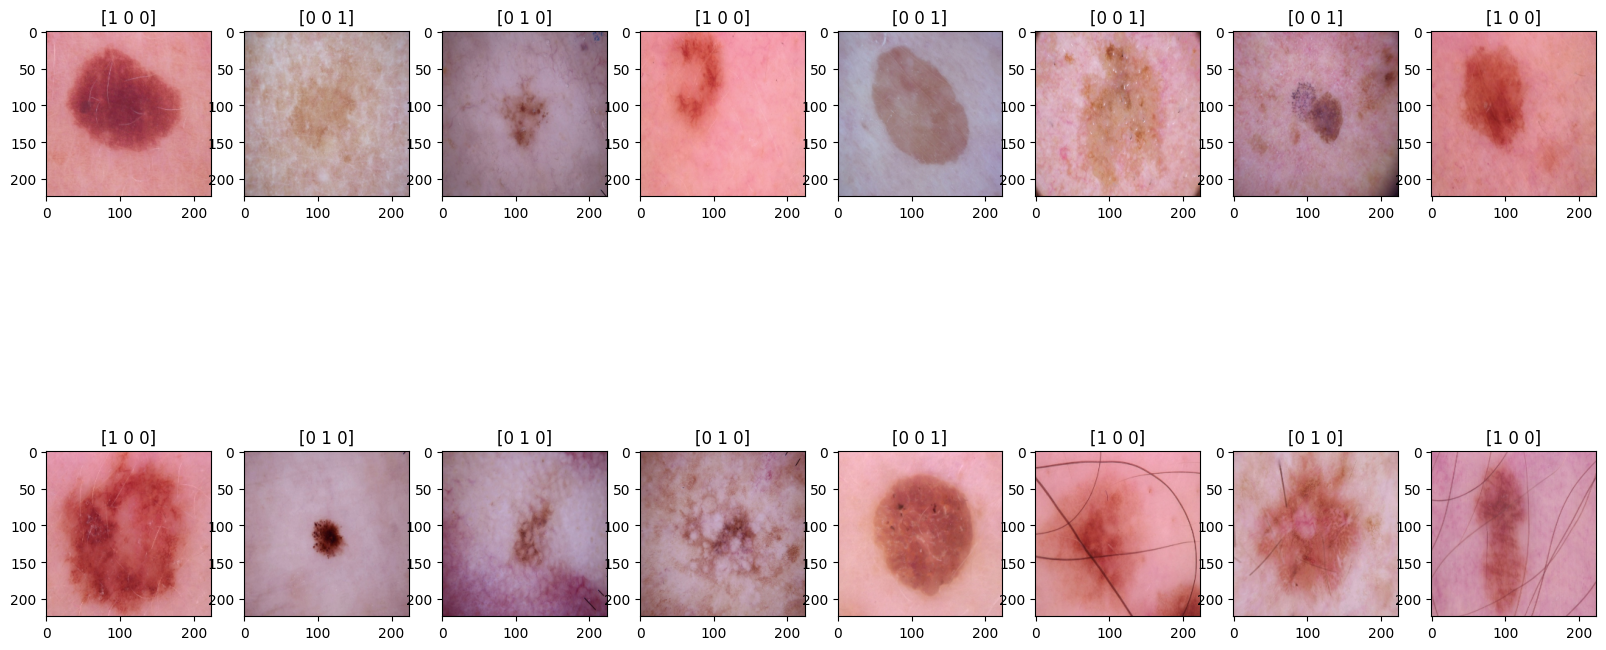

In [9]:
test_idx =5

print("Max index :", test_gen.__len__())
x,y = test_gen.__getitem__(19)

print("x : ",x.shape)
print("y : ",y.shape)

# plot sample
w = 20
h = 25
fig = plt.figure(figsize=(20, 10))
columns = 8  
rows = 2

count_id = 0
for i in range(1, columns*rows +1):
    img = x[count_id]
    cur_label = (y[count_id])


    ax1 = fig.add_subplot(rows, columns, i)
    ax1.set_title(cur_label)
    plt.imshow(img)
    count_id = count_id+1
plt.show()

In [10]:
epochs = 20
base_learning_rate = 1e-3

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

def lr_schedule(epoch,lr):
    # Learning Rate Schedule

    total_epochs = epochs

    check_1 = int(total_epochs * 0.9)
    check_2 = int(total_epochs * 0.8)
    check_3 = int(total_epochs * 0.5)
    check_4 = int(total_epochs * 0.4)

    if epoch > check_1:
        lr *= 1e-5 #0.00001
    elif epoch > check_2:
        lr *= 1e-4 #0.0001
    elif epoch > check_3:
        lr *= 1e-3
    elif epoch > check_4:
        lr *= 1e-2

    print("[+] Current Lr rate : {} ".format(lr))
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate,decay=1e-2)



/Users/tharhtet/.local/share/virtualenvs/tf_best_practices-7uf2K4aY/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
2024-08-09 22:11:48.006199: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-09 22:11:48.006223: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-08-09 22:11:48.006227: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-08-09 22:11:48.006296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-09 22:11:48.006315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (

In [11]:
lr_schedule(10,0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

[+] Current Lr rate : 0.001 


In [12]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
# for customer layer save
checkpoint_path = "training_1/custom_model.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



In [14]:
from tensorflow.keras.layers import Dense,MaxPooling2D,Flatten,Conv2D
from tensorflow.keras.models import Model
import keras

class MyModel(Model):
    def __init__(self,input_shape, output_shape):
        super().__init__()
        self.input_layer = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape= input_shape)
        
        self.conv2d_32 = Conv2D(32, kernel_size=(3,3), activation='relu',)
        self.conv1d_64 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')
        self.conv2d_64 = Conv2D(64, kernel_size=(3,3), activation='relu')
        self.conv2d_128 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')
        self.maxPool_2d =  MaxPooling2D(pool_size=(2,2))
        self.f1 = Flatten()
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(128, activation='relu')

        self.output_layer = Dense(output_shape, activation="sigmoid")
    
    def call(self, x):
        x = self.input_layer(x)
        x = self.conv2d_32(x)
        x = self.maxPool_2d(x)
        x = self.conv1d_64(x)
        x = self.conv2d_64(x)
        x = self.maxPool_2d(x)
        x = self.conv2d_128(x)
        x = self.f1(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.output_layer(x)
        return x

model = MyModel(input_shape = input_shape,output_shape=output_shape)



/Users/tharhtet/.local/share/virtualenvs/tf_best_practices-7uf2K4aY/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop

model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape= input_shape),
    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(128, activation= 'relu'),
    Dense(3, activation='sigmoid')
    
])
"""

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv2D,Dense, Flatten, MaxPooling2D, Dropout\nfrom tensorflow.keras.optimizers import Adam,RMSprop\n\nmodel = Sequential([\n    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape= input_shape),\n    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),\n    MaxPooling2D(pool_size=(2,2)),\n    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),\n    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),\n    MaxPooling2D(pool_size=(2,2)),\n    \n    Flatten(),\n    Dense(128, activation= 'relu'),\n    Dense(3, activation='sigmoid')\n    \n])\n"

In [16]:
model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])

In [17]:
print("Train step per epochs : ",train_gen.__len__())
print("Test step per epochs : ",test_gen.__len__())


history = model.fit(train_gen, epochs=epochs,
                            validation_data=test_gen,
                            callbacks=[ tensorboard_callback,lr_callback,cp_callback])
   

Train step per epochs :  185
Test step per epochs :  20
[+] Current Lr rate : 0.0010000000474974513 
Epoch 1/20


2024-08-09 22:11:56.341988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/tharhtet/.local/share/virtualenvs/tf_best_practices-7uf2K4aY/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5145 - loss: 1.2482on_epoch_end
on_epoch_end

Epoch 1: saving model to training_1/custom_model.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 57s 301ms/step - accuracy: 0.5150 - loss: 1.2460 - val_accuracy: 0.6781 - val_loss: 0.7404 - learning_rate: 0.0010
[+] Current Lr rate : 0.0010000000474974513 
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7032 - loss: 0.6415on_epoch_end
on_epoch_end

Epoch 2: saving model to training_1/custom_model.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - accuracy: 0.7033 - loss: 0.6414 - val_accuracy: 0.7188 - val_loss: 0.6810 - learning_rate: 0.0010
[+] Current Lr rate : 0.0010000000474974513 
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7299 - loss: 0.6081on_epoch_end
on_epoch_end

Epoch 3: saving model to training_1/custom_model.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 53s 286ms/step - accuracy: 0.7300 - loss: 0.6080 - val_accuracy: 0.7219 - val_loss

In [18]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 54, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 373248)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    95,551,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,370,731 (1.07 GB)

 Trainable params: 95,790,243 (365.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 191,580,488 (730.82 MB)

In [19]:
%tensorboard --logdir=logs

UsageError: Line magic function `%tensorboard` not found.


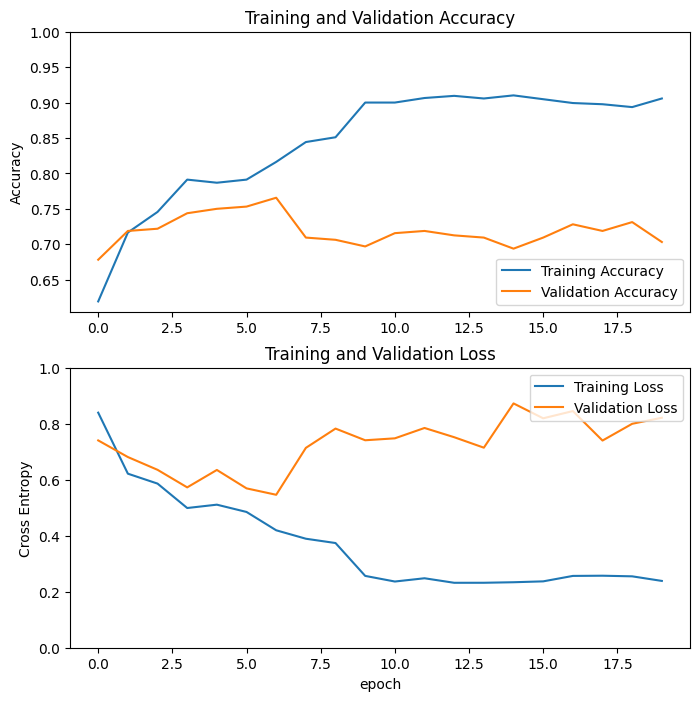

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
test_idx =10
class_labels = ['Melanoma', 'Melanocytic nevi', 'Benign keratosis-like lesions']


print("Max index :", test_gen.__len__())
x,y = test_gen.__getitem__(10)
y_pred = model.predict(x)

Max index : 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [22]:
print("Y_pred : ",class_labels[np.argmax(y_pred[0])])
print("Y_true : ",class_labels[np.argmax(y[0])])

Y_pred :  Melanoma
Y_true :  Melanoma


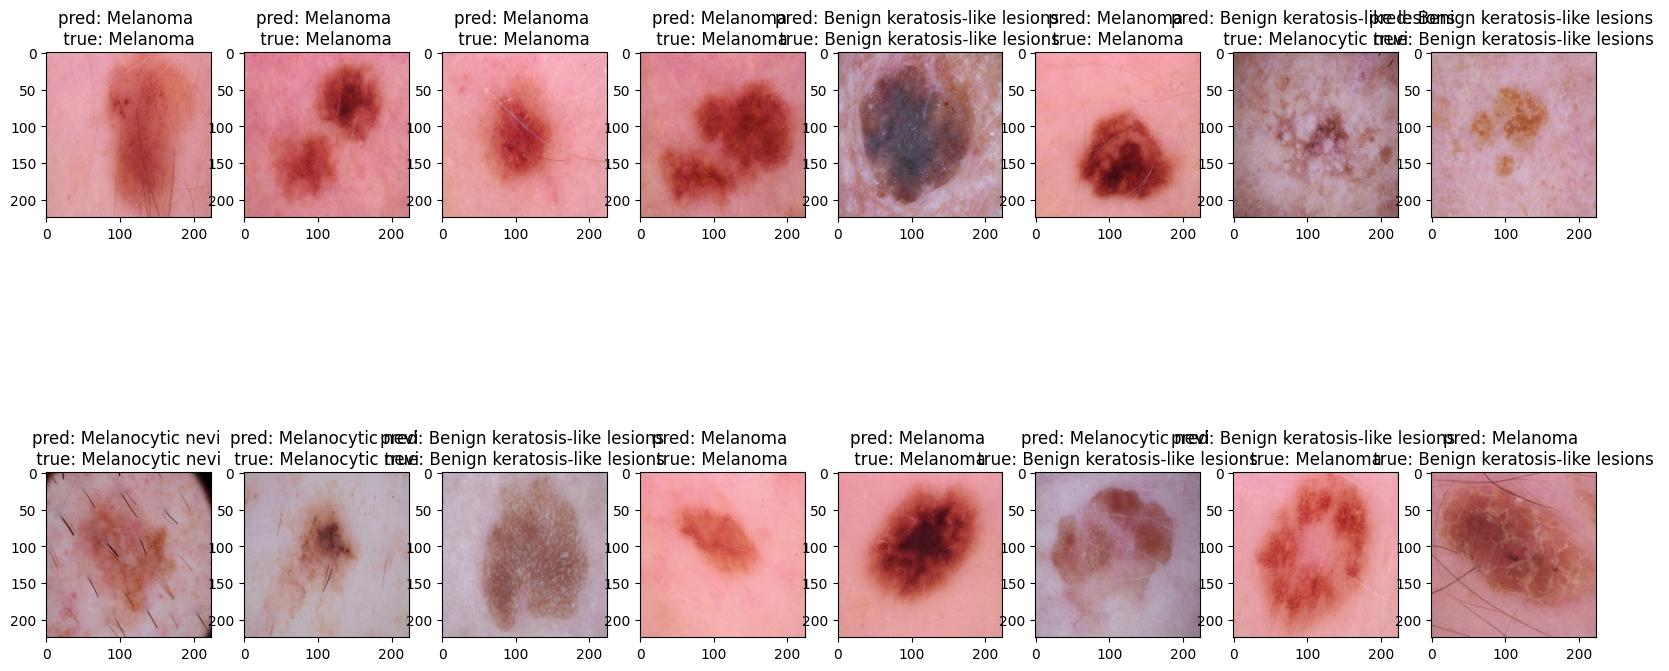

In [23]:
# plot sample
w = 20
h = 25
fig = plt.figure(figsize=(20, 10))
columns = 8  
rows = 2

count_id = 0
for i in range(1, columns*rows +1):
    img = x[count_id]
    cur_label = "pred: {} \n true: {} ".format(class_labels[np.argmax(y_pred[count_id])],class_labels[np.argmax(y[count_id])])

    ax1 = fig.add_subplot(rows, columns, i)
    ax1.set_title(cur_label)
    plt.imshow(img)
    count_id = count_id+1
plt.show()

In [29]:
eval_loss, eval_acc = model.evaluate(test_gen)

print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7106 - loss: 0.8984on_epoch_end
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7116 - loss: 0.8968
Eval loss: 0.8847910165786743, Eval accuracy: 0.715624988079071


####  Save and Load Custom  Model

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3,decay=1e-4)

In [31]:
new_model = MyModel(input_shape = input_shape,output_shape=output_shape)
new_model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])

In [32]:

eval_loss, eval_acc = new_model.evaluate(test_gen)

print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3373 - loss: 1.0986on_epoch_end
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3324 - loss: 1.0986
Eval loss: 1.0988563299179077, Eval accuracy: 0.3031249940395355


In [33]:
checkpoint_path = "training_1/custom_model.weights.h5"
new_model.load_weights(checkpoint_path)

In [34]:

eval_loss, eval_acc = new_model.evaluate(test_gen)

print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7550 - loss: 0.7731on_epoch_end
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7546 - loss: 0.7716
Eval loss: 0.7424343824386597, Eval accuracy: 0.746874988079071


In [39]:
import cv2
import numpy as np
def load_img(img_path):
    img = cv2.imread(img_path)
    img =  img/255
    img_resize = cv2.resize(img,input_size)
    img_reshape = np.array([img_resize])
    return img_reshape


def pred_img(input_img,model):
    label =  ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions']
    pred_ = model.predict(input_img)
    print(pred_)
    pred_label = label[np.argmax(pred_)]
    return pred_label

In [44]:
img_path = os.getcwd()+"/skin_cancer/test/Melanoma/mel_99.jpg"
#img_path = os.getcwd()+"/skin_cancer/test/Melanocytic nevi/nv_926.jpg"
#img_path = os.getcwd()+"/skin_cancer/test/Benign keratosis-like lesions/bkl_90.jpg"
img_path = os.getcwd()+"/skin_cancer/test/Benign keratosis-like lesions/bkl_902.jpg"

img = load_img(img_path)


In [45]:
label =  pred_img(img, new_model)
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[0.05322198 0.69150054 0.9590717 ]]
Benign keratosis-like lesions
